In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
class FT(object):
    """ 
    A Fenwick tree is analogous to a binary heap and provides an 
    efficient prefix sum for counts associated with particular 
    element indices 
    """
    
    @classmethod
    def lsb(self, i):
        return ((i) & (-i))
     
    def __init__(self, size):
        self.elements = None
        self.reset(size)
    
    def sum(self, i):
        result = 0
        i += 1
        while i > 0:
            result += self.elements[i]
            i -= FT.lsb(i)
        return result
    
    def inc_by(self, i, ct):
        i += 1
        while i < len(self.elements) - 1:
            self.elements[i] += ct
            i += FT.lsb(i)
    
    def reset(self, size=None):
        if self.elements is None \
        or (size is not None and size != self.size()):
            self.elements = np.zeros(size + 1)
        else:
            np.ndarray.fill(self.elements, 0.0)
    
    def size(self):
        return len(self.elements) - 1

In the following cell we will define a `TDigest` class that implements the `update` operation for inserting data elements into the sketch. This tutorial implementation does not provide the `merge` operation, which is useful for combining partial results in a distributed computing setting.

In [3]:
class TDigest(object):
    COMPRESSION_DEFAULT = 50.0 / 100.0
    INIT_SIZE_DEFAULT = 5
    K = 10.0 * 50.0
    
    def _reset(self):
        self.centers = np.zeros(1)
        self.masses = np.zeros(1)
        self.nclusters = 0
        self.mass = 0.0
    
    def __init__(self, compression=COMPRESSION_DEFAULT, max_discrete=0, size=INIT_SIZE_DEFAULT):
        self.compression = compression
        self.max_discrete = max_discrete
        self.ft = FT(size)
        self._reset()
    
    def new_cluster(self, insertion_point, sample, weight):
        # note that this will allocate up to two new arrays for 
        # every created cluster (don't do this in real life!)
        
        if self.nclusters >= self.ft.size():
            self.ft.reset(self.nclusters)
        else:
            self.ft.reset()
        
        self.centers = np.insert(self.centers, insertion_point, sample)
        self.masses = np.insert(self.masses, insertion_point, weight)
        for (k, mass) in enumerate(self.masses):
            self.ft.inc_by(k, mass)

        self.nclusters += 1
        self.mass += weight
    
    def _closest(self, sample):
        insertion_point = np.searchsorted(self.centers, sample, 'right')
        
        if insertion_point == self.nclusters:
            return insertion_point - 1
        
        if self.centers[insertion_point] == sample \
        or insertion_point == 0:
            # the closest cluster center is around this 
            # sample or is smaller than any cluster center; 
            # we can rinsertion_pointeturn it unmodified
            return insertion_point
        
        # the insertion point is between two clusters; choose the closest
        dl = sample - self.centers[insertion_point - 1]
        dr = self.centers[insertion_point] - sample
        return (dl < dr) and (insertion_point - 1) or insertion_point
            
    
    def update(self, sample, weight=1.0, maybeRecluster=True):
        def _update(sample, weight):
            if self.nclusters == 0:
                # this is our first observation
                self.centers[0] = sample
                self.mass = self.masses[0] = weight
                self.ft.inc_by(1, weight)
                self.nclusters += 1
                return
                
            if self.nclusters <= self.max_discrete:
                # we can just introduce a new cluster without
                # expanding beyond the maximum number of discrete
                # values we're willing to track
                insertion_point = np.searchsorted(self.centers, sample, 'right')
                if insertion_point < self.nclusters \
                and self.centers[insertion_point] == sample:
                    # landed on existing cluster
                    self.mass += weight
                    self.masses[insertion_point] += weight
                    self.ft.inc_by(insertion_point, weight)
                else:
                    # we need to create a new cluster but don't have
                    # to recluster anything
                    self.new_cluster(insertion_point, sample, weight)
                return

            insertion_point = self._closest(sample)
            if insertion_point < self.nclusters \
            and sample == self.centers[insertion_point]:
                # we have a cluster centered around this sample
                self.mass += weight
                self.masses[insertion_point] += weight
                self.ft.inc_by(insertion_point, weight)
                return
            
            m = self.masses[insertion_point]
            
            q = (self.ft.sum(insertion_point - 1) + (m / 2.0)) / self.mass
            
            ub = self.compression * self.mass * q * (1.0 - q)
            
            delta_mass = min(weight, max(0.0, ub - m))
            
            remaining_mass = weight - delta_mass
            if delta_mass > 0.0:
                dc = delta_mass * (sample - self.centers[insertion_point]) / (m + delta_mass)
                self.centers[insertion_point] += dc
                self.mass += delta_mass
                self.masses[insertion_point] += delta_mass
                self.ft.inc_by(insertion_point, delta_mass)
            if remaining_mass > 0.0:
                insertion_point += (sample < self.centers[insertion_point] and 0 or 1)
                self.new_cluster(insertion_point, sample, remaining_mass)
        
        _update(sample, weight)
        
        if (maybeRecluster \
        and self.nclusters > self.max_discrete \
        and self.nclusters > self.r()):
            self.recluster()
    
    def recluster(self):
        indices = list(range(self.nclusters))
        np.random.shuffle(indices)
        old_centers = self.centers
        old_masses = self.masses
        self._reset()
        
        for i in indices:
            self.update(old_centers[i], old_masses[i], False)
    
    def _rcovj(self, x):
        """ return the left index of a right cover """
        j = np.searchsorted(self.centers, x, 'right')
        if j == self.nclusters:
            return j - 1
        
        if self.centers[j] == x:
            return j
        
        return j - 1
    
    def _rmcovj(self, m):
        assert(self.nclusters >= 2)
        assert((m >= 0.0) and (m <= self.mass))
        beg = 0
        mbeg = 0.0
        end = self.nclusters - 1
        mend = self.mass
        while (end - beg) > 1:
            mid = int((beg + end) / 2)
            mmid = self.ft.sum(mid)
            if m >= mmid:
                beg = mid
                mbeg = mmid
            else:
                end = mid
                mend = mmid
        return beg
        
    def cdf(self, x):
        j1 = self._rcovj(x)
        if j1 < 0:
            return 0.0
        if j1 == self.nclusters - 1:
            return 1.0
        
        j2 = j1 + 1
        c1, c2 = self.centers[j1], self.centers[j2]
        tm1, tm2 = self.masses[j1], self.masses[j2]
        s = self.ft.sum(j1 - 1)
        d1 = 0.0 if (j1 == 0) else (tm1 / 2.0)
        m1 = s + d1
        m2 = m1 + (tm1 - d1) + (tm2 if (j2 == self.nclusters - 1) else (tm2 / 2.0))
        m = m1 + (x - c1) * (m2 - m1) * (c2 - c1)
        return min(m2, max(m1, m)) / self.mass
    
    def cdfi(self, q):
        if q < 0.0 or q > 1.0 or self.nclusters == 0:
            return np.nan
        
        if self.nclusters == 1:
            return self.centers[0]
        
        m = q * self.mass
        j1 = self._rmcovj(m)
        j2 = j1 + 1
        
        c1, c2 = self.centers[j1], self.centers[j2]
        tm1, tm2 = self.masses[j1], self.masses[j2]
        s = self.ft.sum(j1 - 1)
        d1 = 0.0 if (j1 == 0) else (tm1 / 2.0)
        m1 = s + d1
        m2 = m1 + (tm1 - d1) + (tm2 if (j2 == self.nclusters - 1) else (tm2 / 2.0))
        
        x = c1 + (m - m1) * (c2 - c1) / (m2 - m1)
        return min(c2, max(c1, x))
    
    def r(self):
        return int(TDigest.K / self.compression)

sketch some data. This data is Poisson distributed. Perhaps it represents query latencies you are measuring for one of your microservices

In [4]:
import scipy.stats

sketch = TDigest(compression = 0.1)

for p in scipy.stats.gamma.rvs(7, 1, size=100000):
    sketch.update(p)

visualize the CDF of your data

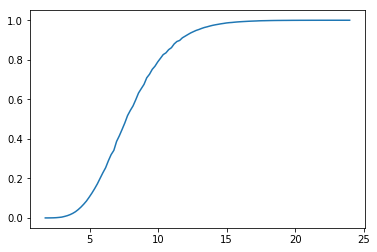

In [5]:
def plotCDF(tdigest):
    xmin = sketch.cdfi(0)
    xmax = sketch.cdfi(1)
    xdata = np.arange(xmin,xmax,0.2).tolist()
    ydata = [sketch.cdf(x) for x in xdata]
    plt.plot(xdata, ydata)

plotCDF(sketch)

Get quantiles from your data. Here we are looking at median (q=0.5), the 90th percentile and the 99.9th percentile. You can use quantiles such as these to answer questions such as "am I meeting the desired SLA for query latencies?"

In [6]:
[sketch.cdfi(0.5), sketch.cdfi(0.9), sketch.cdfi(0.999)]

[7.620332391072656, 11.475163945538313, 18.76554459398662]

Inverse Transform Sampling

In [7]:
def sample(tdigest, size=1):
    from scipy.stats import uniform
    q = uniform.rvs(size=size).tolist()
    return [tdigest.cdfi(y) for y in q]

In [8]:
sample(sketch, size=10)

[6.941058022963125,
 10.219147189787993,
 4.585751057447321,
 3.9790587305169764,
 7.918148039924358,
 6.939783573668153,
 8.065408298874738,
 7.978447246753223,
 8.808414324768068,
 8.557991936896212]

T-Digest as a Generative Model

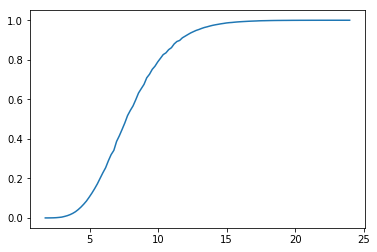

In [9]:
sketchSyn = TDigest(compression = 0.1)
for x in sample(sketch, size=10000):
    sketchSyn.update(x)

plotCDF(sketchSyn)